In [1]:
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt
import os

In [2]:
def plotGauss(vals,base,a,mean,sig):
    """Plot a guassian dist with the given x, can be arr or single value"""
    return base+a*np.exp(-((vals-mean)**2)/(2*sig**2))

In [3]:
from scipy import optimize
def gaussian(x, amplitude, mean, stddev):
    """Plot a guassian dist with the given x, can be arr or single value"""
    return amplitude * np.exp(-((x - mean) / np.sqrt(2) / stddev)**2)

def plotPrep(arr,binnum=50):
    """Prepare arr for plotting, histogramming it and returning the hist counts along with the middle of the bin 
        x-values"""
    vals, edges = np.histogram(arr,bins=binnum)
    binwidth = (edges[1]-edges[0])/2
    midbin = edges[:-1]+binwidth
    
    return vals, midbin

def gaussianFit(midbin,vals):
    '''Fit a gaussian to data, returning the distribution at midbin values'''
    base = np.average(np.concatenate((vals[1:10],vals[-10:-1]))); adjvals = vals-base
    berr = np.std(np.concatenate((vals[1:10],vals[-10:-1])))/np.sqrt(len(np.concatenate((vals[1:10],vals[-10:-1]))))
    popt, pcov = optimize.curve_fit(gaussian, midbin, adjvals)
    gausvals = gaussian(midbin,*popt)+base
    argerr = np.sqrt(np.diag(pcov))/np.sqrt(sum(vals))
    print("Base:",base,"±",berr,"\nAmplitude:", popt[0],"±",argerr[0], "\nMean:", popt[1],"±",argerr[1],"\nStd. Dev:", popt[2],"±",argerr[2])
    return gausvals

In [5]:
def smear(data,width=3.5):
    """Smear the simulation data, once for each sDOM the default width is 3.5ns even though
        we found that 7ns matched the data better, we could not find why so it is kept at 3.5ns"""
    FWHM=width
    sig = FWHM/(2*np.sqrt(2*np.log(2)))
    rng = np.random.default_rng()
    rvals1 = rng.normal(loc=0,scale=sig,size=len(data))
    rvals2 = rng.normal(loc=0,scale=sig,size=len(data))
    
    return rvals1+rvals2+data

In [5]:
coin = np.loadtxt('Data/Veff/vEffCoincs.txt',delimiter="\t")
#add path, should be in some data dir if I forget to update this
nGen = np.loadtxt('Data/Veff/nGen.txt',delimiter="\t")

In [18]:
def Vr(r,carr,nG,ws): #r in centimetres
    '''Get effective volume for a given radius in cm along with the error 
        and the number of coincidences within that volume'''
    hitList = ws[carr.T[3]<r]
    nco = np.sum(hitList) #sum the weights to get the number of coincidences
    gen = nG*(r/2000)**3
    frac = nco/gen
    nerrPercent = np.sqrt(len(hitList))/len(hitList) #consider all hits as weight 1 for error calc
    
    vgen = 4/3*np.pi*r**3
    veff = frac*vgen
    veffErr = nerrPercent*veff
    return veff,nco,veffErr #in cm3

# Better QE

In [6]:
true = np.loadtxt('Data/QE_coinc/true.txt',delimiter="\t")
tweight = np.loadtxt('Data/QE_coinc/tweight.txt',delimiter="\t")
all_ = np.loadtxt('Data/QE_coinc/all.txt',delimiter="\t")
aweight = np.loadtxt('Data/QE_coinc/aweight.txt',delimiter="\t")
#path should be here, in the data dir if I forget

In [8]:
def get_nvals(nvalDir):
    '''Get the number of generated K40 atoms from the files'''
    ns = os.listdir(nvalDir)
    nvals = []
    for f in ns:
        n = np.loadtxt(nvalDir+f,delimiter="\t")
        nvals.append(n)
    nvals = np.array(nvals)
    return nvals

In [11]:
#combine files from cedar and illume into one array
invals = get_nvals('Data/QE_coinc/invals/')
cnvals1 = get_nvals('Data/QE_coinc/cnvals/nGen/')
nvals1 = np.concatenate((invals,cnvals1))
np.shape(nvals1)

(20001,)

In [13]:
nv = []
for n in nvals1:
    try:
        nv=nv+list(n)
    except TypeError:
        nv.append(n)
len(nv)

880094

In [49]:
testvals = get_nvals('Data/QE_coinc/cnvals/nfiles/')
nvals2 = []
for l in testvals:
    nvals2 = nvals2 + list(l)
nvals2 = np.array(nvals2)

In [14]:
#nvals = np.concatenate((nvals1,nvals2))
nvals = nv
len(nvals)

880094

In [15]:
#get the effective volume for the entire sphere
Vgen = 4/3*np.pi*20**3
f = np.sum(tweight)/np.sum(nvals)
Ve = Vgen*f #tweight is same length as true so summing give all with QE
print("Effective Volume: %.4g m3" % Ve)

Effective Volume: 6.471e-06 m3


In [19]:
#get ready to plot the effective volume as a function of radius
veffs = []
nr = []
ver = []
for i in np.arange(1,21,1):
    v,n,ve = Vr(i*100,true,np.sum(nvals),tweight)
    veffs.append([i,v])
    nr.append(n)
    ver.append(ve)
veffs = np.array(veffs)

In [20]:
ver[-4:] #check error in effective vol

[0.12371210990901374,
 0.12369234350513386,
 0.12382730556255986,
 0.12382730556255983]

<IPython.core.display.Javascript object>


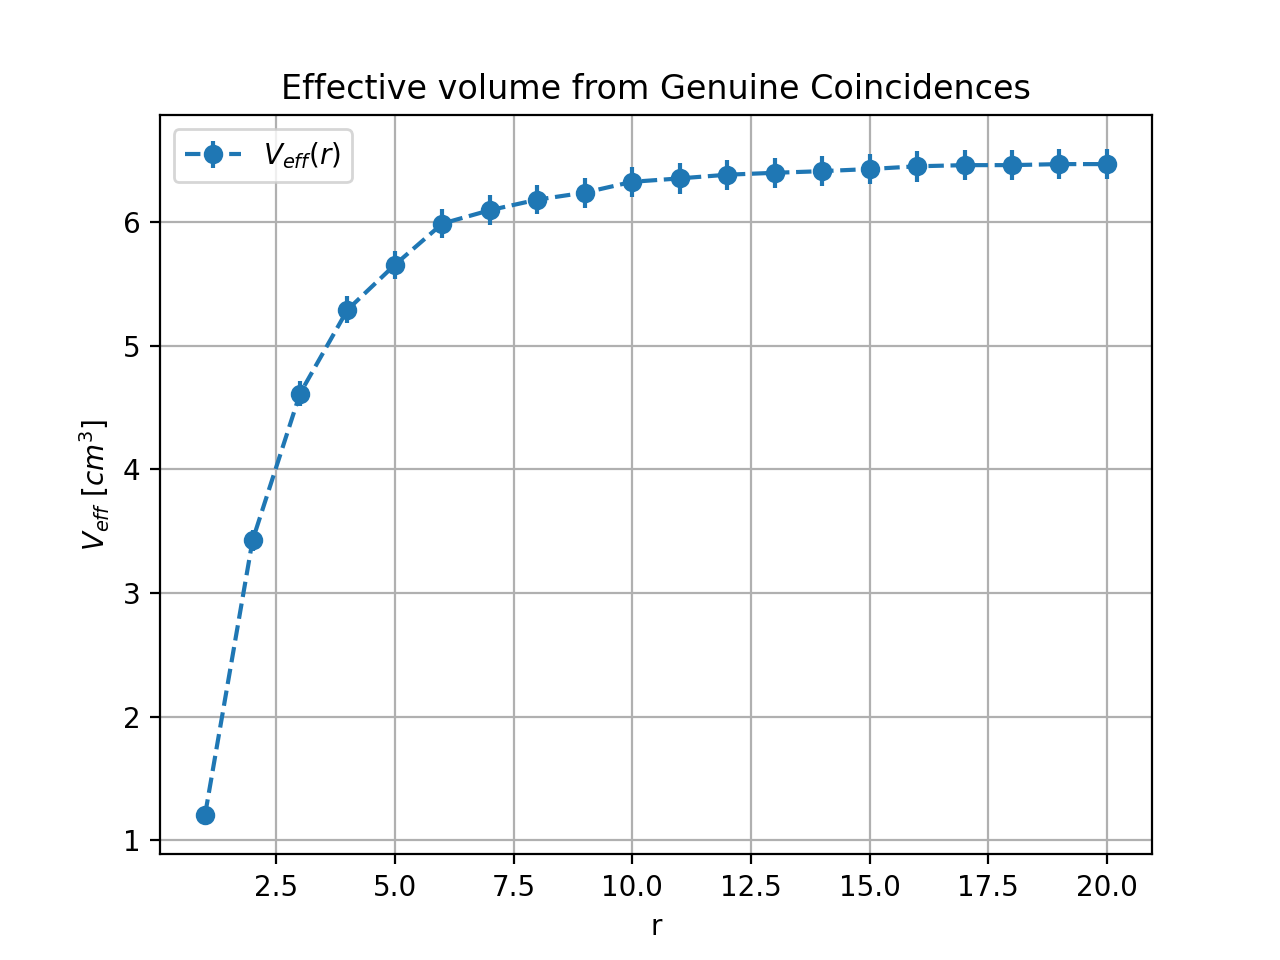

In [21]:
#plot our findings
plt.close()
plt.figure()
plt.errorbar(veffs.T[0],veffs.T[1],yerr=np.array(ver),label=r'$V_{eff}\left(r\right)$',fmt='o--')
plt.title("Effective volume from Genuine Coincidences")
plt.legend(loc=2)
plt.xlabel("r")
plt.ylabel(r'$V_{eff}$ [$cm^3$]')
plt.grid()
plt.show()